## **Example. Estimating a population total under simple random sampling using transformed normal models**

In [182]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
from theano import shared
import random
from scipy.optimize import fsolve, root
import statistics as stat
import math

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

List of populations of cities and towns in New York State in 1960,
used in the first example of Section 7.6 and summarized in Table 7.2
of Bayesian Data Analysis.  Code = 400 if included in Sample 1 only; 300 if
included in Sample 2 only; 200 if included in both samples; 100 if
included in neither sample.

In [2]:
new_york = np.genfromtxt('data/newyork.txt', skip_header=7, dtype=(int, int))
print(new_york.shape)

(804, 2)


Let's find the sample 1 and sample 2.

In [3]:
sample1 = []
sample2 = []

for i, j in new_york[:, :]:
    if j == 400 or j == 200:
        sample1.append(i)
    if j == 300 or j == 200:
        sample2.append(i)
        
sample1.sort()
sample2.sort()

In [4]:
sample2.sort()
inds = [1, 2, 3, 4, 5]
for i in sorted(inds, reverse=True):
    del sample2[i]
    
sample2.append(1425350)

In [5]:
print(stat.mean(sample2))
print(stat.stdev(sample2))
print(len(sample2))

38176
228625.92525783248
100


With sample 1.

In [6]:
def logp_(value):
    return tt.log(tt.pow(value, -1))


with pm.Model() as model_1:
    y_obs = pm.Uniform('mu', lower=-5e5, upper=5e5)
    sigma_obs = pm.Uniform('sigma', lower=0, upper=5e5)
    pm.Potential('simga_log', logp_(sigma_obs))
    y_bar = pm.Normal('y_bar', mu=y_obs, sd=sigma_obs, observed=sample1)

In [7]:
with model_1:
    trace_1 = pm.sample(draws=2_000, tune=4_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:09<00:00, 2622.39draws/s]


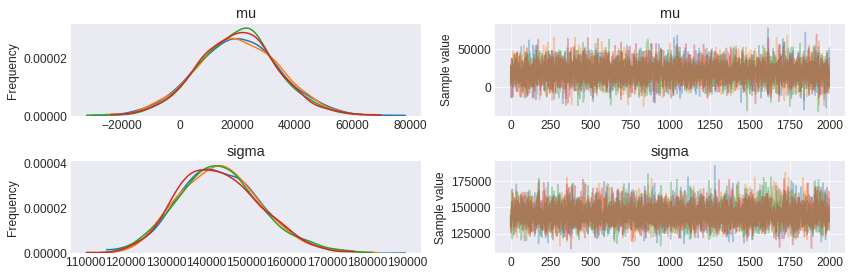

In [24]:
pm.traceplot(trace_1, varnames=['mu', 'sigma']);

In [9]:
df = pm.summary(trace_1, varnames=['mu', 'sigma'])
df

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,20005.346759,13945.627615,146.177060,-7687.079695,47250.206411,7669.784559,0.999768
sigma,143262.012876,10216.385774,111.129472,123838.211999,163635.868402,7081.729934,1.000003


In [10]:
with model_1:
    ppc_1 = pm.sample_posterior_predictive(trace_1, samples=500, vars=[y_bar])

100%|██████████| 500/500 [00:00<00:00, 1588.83it/s]


In [11]:
ppc_1['y_bar'].shape

(500, 100)

In [12]:
lst_num1 = []

for j in range(ppc_1['y_bar'].shape[0]):
    temp_list = []
    for i in ppc_1['y_bar'][j][:]:
        i = int(i)
        if i not in sample1:
            print(j, i)
            temp_list.append(i)
            
    temp_num = len(sample1) * stat.mean(sample1) / len(new_york) + \
        (len(new_york) - len(sample1)) / len(new_york) * stat.mean(temp_list)
    lst_num1.append(temp_num)

0 176986
0 -245405
0 -196713
0 -337675
0 -146437
0 56833
0 191794
0 -135090
0 75515
0 5260
0 88672
0 33041
0 152814
0 -242860
0 414998
0 -252322
0 5
0 -110385
0 -82381
0 170012
0 8694
0 87256
0 187906
0 -301291
0 -168419
0 157081
0 -60890
0 -154400
0 152347
0 257088
0 207240
0 135614
0 42368
0 308353
0 149593
0 113250
0 135631
0 -8438
0 62696
0 -1982
0 -170631
0 -231767
0 97099
0 257587
0 -61138
0 277551
0 93777
0 -106267
0 -18823
0 -104712
0 249327
0 130530
0 -92228
0 -39647
0 423
0 -6236
0 11443
0 -120106
0 37127
0 -77925
0 58585
0 106824
0 -84294
0 149752
0 -82866
0 42856
0 30480
0 132159
0 -3093
0 134236
0 55863
0 8812
0 -113074
0 4343
0 -287457
0 -34739
0 -35354
0 -104072
0 -124789
0 104108
0 -80818
0 177950
0 -82037
0 -55381
0 -44877
0 113541
0 35394
0 -69250
0 55555
0 -159165
0 107233
0 100966
0 36294
0 24585
0 36910
0 -233287
0 -244049
0 54667
0 151533
0 -108674
1 -196518
1 139464
1 -167271
1 -48495
1 239880
1 -85905
1 197082
1 -242565
1 128377
1 -64957
1 -137398
1 223946
1 692

In [13]:
stat.mean(lst_num1)

20742.13380333886

In [14]:
sum(sample1)

1966745

We repeat the above analysis under the assumption that the $N = 804$ values in the
complete data follow a lognormal distribution

In [15]:
with pm.Model() as model_1_log:
    y_obs = pm.Uniform('mu', lower=0, upper=5e2)
    sigma_obs = pm.Uniform('sigma', lower=0, upper=5e2)
#     pm.Potential('simga_log', logp_(sigma_obs))
    y_bar = pm.Lognormal('y_bar', mu=y_obs, sd=sigma_obs, observed=sample1)

In [16]:
with model_1_log:
    trace_2 = pm.sample(draws=2000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2734.81draws/s]


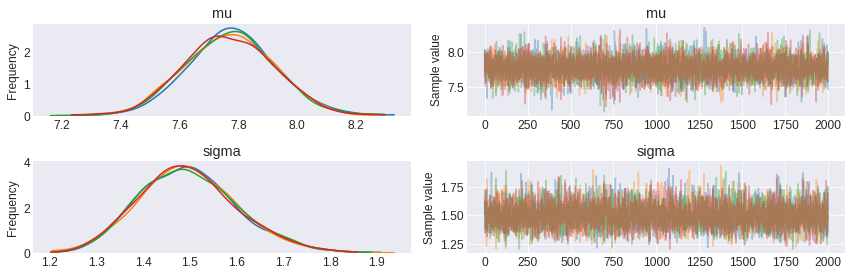

In [25]:
pm.traceplot(trace_2, varnames=['mu', 'sigma']);

In [18]:
df2 = pm.summary(trace_2, varnames=['mu', 'sigma'])
df2

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,7.770005,0.150732,0.001863,7.476127,8.059644,7438.363602,1.000537
sigma,1.496778,0.105871,0.001213,1.289813,1.702997,7501.760160,0.999798


In [53]:
with model_1_log:
    ppc_1_log = pm.sample_posterior_predictive(trace_2, samples=100, vars=[y_bar, y_obs, sigma_obs])

100%|██████████| 100/100 [00:00<00:00, 2458.40it/s]


Para `y_bar`

In [64]:
ppc_1_log['y_bar'].shape # buena
# np.mean(np.mean(ppc_1_log['y_bar'], axis=1)) # mala

(100, 100)

Para hallar $y_{mis}$

In [83]:
y_miss_1 = []

for i, j  in zip(ppc_1_log['mu'], ppc_1_log['sigma']):
    tam = np.exp(np.random.normal(loc=i, scale=j, size=100))
    y_miss_1.append(np.mean(tam))
    
y_miss_1 = np.array(y_miss_1)

In [46]:
n_random = np.random.normal(loc=ppc_1_log['mu'], scale=ppc_1_log['sigma'])
y_miss = np.exp(n_random)

Ahora se halla

$$y_{total} = N \cdot y = n\cdot y_{obs} + (N − n)y_{mis}$$

In [84]:
y_total = 100 * np.mean(ppc_1_log['y_bar'], axis=1) + 704 * y_miss_1

In [87]:
print(np.mean(y_total))
int(np.percentile(y_total, 2.5)), int(np.percentile(y_total, 97.5)) # sí funciona

5945097.470865407


(3668709, 9474746)

#### Sample 1: checking the lognormal model.

In [220]:
np.sum(np.sum(ppc_1_log['y_bar'], axis=1) >= sum(sample1))

SyntaxError: unexpected EOF while parsing (<ipython-input-220-846cf16fe8e4>, line 2)

Sólo 2 de 100 dan una suma mayor que `sum(sample1)`

#### Sample 1: extended analysis.

In [131]:
phi = np.linspace(-1, 0, num=9)
phi

array([-1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375, -0.25 , -0.125,
        0.   ])

In [194]:
def box_cox(data, phi):
    
    if phi == 0:
        return np.log(data)
    else:
        return (data**phi - 1) / phi
    
def invbox_cox(data, phi):
    if phi == 0:
        return np.exp(data)
    else:
        return np.exp(np.log(data * phi + 1) / phi)
        
sample1 = np.array(sample1)
# print(sample1)
invbox_cox(box_cox(sample1, -1.4), -1.4)

array([1.64000000e+02, 1.71000000e+02, 1.80000000e+02, 2.50000000e+02,
       3.03000000e+02, 3.14000000e+02, 3.27000000e+02, 3.32000000e+02,
       3.73000000e+02, 3.99000000e+02, 4.20000000e+02, 4.25000000e+02,
       4.46000000e+02, 5.07000000e+02, 5.20000000e+02, 6.99000000e+02,
       7.00000000e+02, 7.20000000e+02, 7.32000000e+02, 7.43000000e+02,
       8.00000000e+02, 8.34000000e+02, 8.42000000e+02, 8.76000000e+02,
       8.87000000e+02, 8.96000000e+02, 9.00000000e+02, 9.31000000e+02,
       9.50000000e+02, 9.56000000e+02, 9.56000000e+02, 1.02700000e+03,
       1.04000000e+03, 1.07900000e+03, 1.10900000e+03, 1.14900000e+03,
       1.16600000e+03, 1.18000000e+03, 1.24400000e+03, 1.24700000e+03,
       1.38200000e+03, 1.39000000e+03, 1.53300000e+03, 1.55000000e+03,
       1.64700000e+03, 1.69000000e+03, 1.71400000e+03, 1.74900000e+03,
       1.86300000e+03, 2.08000000e+03, 2.08300000e+03, 2.14300000e+03,
       2.16000000e+03, 2.21300000e+03, 2.40300000e+03, 2.46100000e+03,
      

In [148]:
data_transformed = box_cox(sample1, -0.8)

with pm.Model() as model_trans:
    y_obs = pm.Uniform('mu', lower=0, upper=5e2)
    sigma_obs = pm.Uniform('sigma', lower=0, upper=5e2)
#     pm.Potential('simga_log', logp_(sigma_obs))
    y_phi = pm.Normal('y_phi', mu=y_obs, sd=sigma_obs, observed=data_transformed)

https://stats.stackexchange.com/questions/337527/parameter-lambda-of-box-cox-transformation-and-likelihood

In [149]:
with model_trans:
    trace_3 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1185.35draws/s]


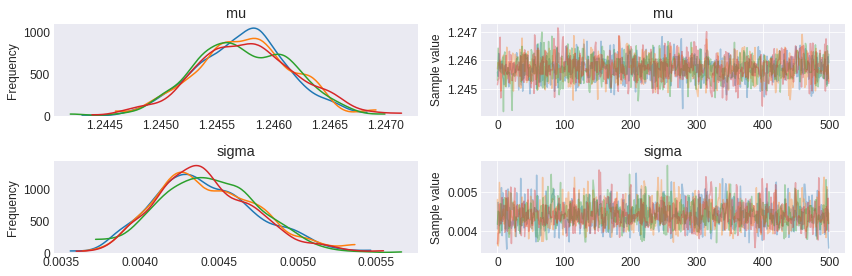

In [150]:
pm.traceplot(trace_3);

In [151]:
with model_trans:
    ppc_trans = pm.sample_posterior_predictive(trace_3, samples=100, vars=[y_phi])

100%|██████████| 100/100 [00:00<00:00, 956.33it/s]


In [156]:
ppc_trans['y_phi'][:, 0], sampl

array([1.24415077, 1.2497625 , 1.24955236, 1.24680177, 1.24881921,
       1.2482621 , 1.24656537, 1.24291706, 1.24567975, 1.24216841,
       1.2389802 , 1.24920718, 1.24725278, 1.24720599, 1.24547498,
       1.24175916, 1.24786943, 1.2415712 , 1.24211767, 1.23864996,
       1.25616449, 1.25262331, 1.24427174, 1.23727952, 1.24304291,
       1.24868809, 1.24260239, 1.23977413, 1.24163447, 1.25049225,
       1.24757124, 1.24372769, 1.24132579, 1.24654732, 1.24429255,
       1.25208704, 1.24601284, 1.23580548, 1.24479415, 1.2477358 ,
       1.24600168, 1.24069853, 1.25062981, 1.25224332, 1.24006225,
       1.24819762, 1.25007492, 1.24441928, 1.24844254, 1.24750281,
       1.23791557, 1.25243057, 1.24524386, 1.24229005, 1.25287927,
       1.23917749, 1.24331439, 1.24439442, 1.25220467, 1.24476358,
       1.24487296, 1.24506766, 1.24393954, 1.24907177, 1.24465645,
       1.25117543, 1.2413794 , 1.24951891, 1.25129817, 1.24148494,
       1.24454601, 1.24688054, 1.24712952, 1.24378511, 1.24070

In [154]:
data_transformed

array([1.22886341, 1.22955848, 1.23038032, 1.23491456, 1.23706531,
       1.2374291 , 1.23783053, 1.23797737, 1.23904675, 1.23962157,
       1.24003882, 1.24013269, 1.24050616, 1.24143152, 1.24160333,
       1.24337283, 1.2433804 , 1.24352792, 1.24361294, 1.2436887 ,
       1.24405108, 1.2442459 , 1.24428968, 1.24446769, 1.24452264,
       1.2445667 , 1.24458603, 1.24473073, 1.24481521, 1.24484126,
       1.24484126, 1.2451286 , 1.24517738, 1.24531734, 1.24541895,
       1.24554699, 1.245599  , 1.24564082, 1.24582118, 1.24582922,
       1.24615848, 1.24617617, 1.24646429, 1.24649535, 1.24666147,
       1.2467296 , 1.24676629, 1.24681816, 1.2469749 , 1.24723013,
       1.24723332, 1.24729547, 1.24731251, 1.24736412, 1.24753222,
       1.24757886, 1.24762506, 1.24774721, 1.24782195, 1.24788554,
       1.24788902, 1.2479325 , 1.24803415, 1.2481073 , 1.24830921,
       1.24832792, 1.24835546, 1.24836593, 1.24837176, 1.24842725,
       1.24845386, 1.24862877, 1.24869446, 1.24875805, 1.24881

In [146]:
from scipy import stats
stats.boxcox(sample1)[1]

-0.1688902053661071

In [214]:
data_transformed = box_cox(sample1, -0.168)
print(data_transformed)

with pm.Model() as model_trans:
    y_obs = pm.Uniform('mu', lower=0, upper=1e2)
    sigma_obs = pm.Uniform('sigma', lower=0, upper=5e1)
#     pm.Potential('simga_log', logp_(sigma_obs))
    y_phi = pm.Normal('y_phi', mu=y_obs, sd=sigma_obs, observed=data_transformed)

[3.42542919 3.44311108 3.46464125 3.5982165  3.67304492 3.68665939
 3.70204843 3.70777805 3.75126139 3.77603831 3.79471188 3.79899747
 3.81637498 3.86188476 3.87075757 3.97168163 3.97215728 3.98150696
 3.98697233 3.99189111 4.01608561 4.02957782 4.0326592  4.04538387
 4.04937761 4.05260243 4.05402356 4.06479311 4.07118883 4.07317754
 4.07317754 4.09565895 4.0995785  4.11100225 4.1194664  4.13034495
 4.13483516 4.13847594 4.15450015 4.15522753 4.18599596 4.18770799
 4.2165012  4.2197144  4.2372938  4.24470386 4.24874459 4.25452035
 4.27243636 4.30324645 4.30364571 4.31149275 4.3136695  4.32032952
 4.34275826 4.34919475 4.35566935 4.37327594 4.38442439 4.39415139
 4.39468957 4.40148378 4.41781591 4.42998801 4.46562864 4.46909909
 4.47426335 4.47624515 4.47735184 4.48805343 4.49329253 4.52961801
 4.54421019 4.55889809 4.5715391  4.57647723 4.58397031 4.58775549
 4.60047232 4.61325577 4.61397469 4.61984323 4.66646716 4.6671745
 4.66916405 4.689818   4.73817359 4.74659061 4.75845351 4.78937

In [164]:
with model_trans:
    trace_4 = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:03<00:00, 2519.60draws/s]


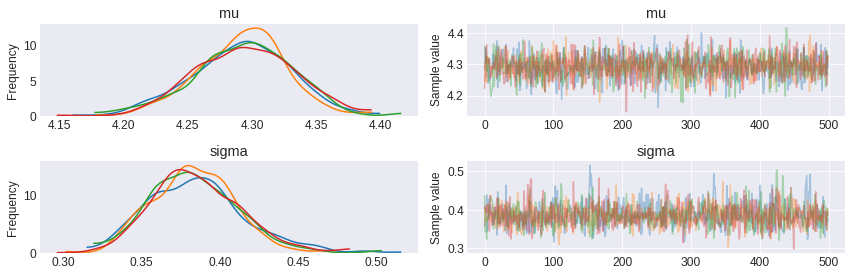

In [165]:
pm.traceplot(trace_4);

In [166]:
pm.summary(trace_4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.292427,0.036803,0.000753,4.221242,4.362909,2052.484390,0.999559
sigma,0.384372,0.028826,0.000665,0.329223,0.439491,1717.331119,1.000104


In [202]:
with model_trans:
    ppc_trans = pm.sample_posterior_predictive(trace_4, samples=100, vars=[y_phi, y_obs, sigma_obs])

100%|██████████| 100/100 [00:00<00:00, 1597.78it/s]


In [213]:
ppc_trans['y_phi']

array([[4.78905464, 4.5086867 , 4.40879879, ..., 4.03972193, 4.85546379,
        3.72074712],
       [3.88165144, 4.05110315, 5.06840532, ..., 4.24460787, 4.04210947,
        4.5901626 ],
       [3.38155041, 4.01640758, 4.55544757, ..., 4.20453334, 4.85626851,
        4.41367051],
       ...,
       [4.17022192, 4.3545911 , 4.53769838, ..., 4.76096439, 3.96750846,
        4.55181972],
       [4.53580873, 4.19911097, 4.33018894, ..., 4.6570777 , 5.16019927,
        3.47579781],
       [4.11142263, 4.7614262 , 3.06058173, ..., 4.89546867, 3.93178113,
        4.44566467]])

In [205]:
invbox_cox(ppc_trans['y_phi'], -0.168)

array([[1.66025050e+04, 4.59194810e+03, 3.08356695e+03, ...,
        8.60677130e+02, 2.35572357e+04, 3.43651111e+02],
       [5.36497288e+02, 8.91802507e+02, 8.51259672e+04, ...,
        1.68943463e+03, 8.67100028e+02, 6.48883320e+03],
       [1.48026979e+02, 8.00792274e+02, 5.58615813e+03, ...,
        1.47156915e+03, 2.36603683e+04, 3.14213689e+03],
       ...,
       [1.31076661e+03, 2.51089025e+03, 5.18172647e+03, ...,
        1.44043792e+04, 6.90297563e+02, 5.50057938e+03],
       [5.14071810e+03, 1.44468560e+03, 2.29427564e+03, ...,
        8.75742773e+03, 1.63488656e+05, 1.84880751e+02],
       [1.08046744e+03, 1.44376584e+04, 7.34862093e+01, ...,
        2.93876805e+04, 6.20753387e+02, 3.56076303e+03]])

In [227]:
y_miss_2 = []

for i, j  in zip(ppc_trans['mu'], ppc_trans['sigma']):
    tam = np.random.normal(loc=i, scale=j, size=100)
    y_miss_2.append(np.mean(tam))
    
y_miss_2 = np.array(y_miss_2)
y_miss_2

array([4.23300202, 4.3588398 , 4.36314712, 4.27403943, 4.26918597,
       4.19753098, 4.28073711, 4.31625826, 4.1975703 , 4.29749475,
       4.34417311, 4.30948027, 4.31213426, 4.36352895, 4.24055377,
       4.23450732, 4.34928366, 4.32842547, 4.44603003, 4.29050204,
       4.3103585 , 4.30633198, 4.33841374, 4.2755498 , 4.3406495 ,
       4.37221706, 4.28746193, 4.32114672, 4.30268147, 4.33433428,
       4.36230862, 4.37866248, 4.1868796 , 4.32029228, 4.29543328,
       4.31306489, 4.20082657, 4.31632044, 4.27389341, 4.24883555,
       4.30435062, 4.30956347, 4.3119811 , 4.2755002 , 4.32113483,
       4.2340414 , 4.31047487, 4.38806006, 4.26300247, 4.250749  ,
       4.30880058, 4.20292185, 4.2363933 , 4.27549241, 4.26336096,
       4.31141599, 4.28022641, 4.2177181 , 4.29037321, 4.28597048,
       4.26764004, 4.2355582 , 4.27653967, 4.29497243, 4.20658479,
       4.39989805, 4.33910483, 4.22859425, 4.24846675, 4.32722232,
       4.21332321, 4.32477416, 4.32102615, 4.22353141, 4.31187

In [228]:
y_total_2 = 100 * np.mean(invbox_cox(ppc_trans['y_phi'], -0.168), axis=1) + 704 * invbox_cox(y_miss_2, -0.168)
y_total_2

array([1.65193358e+06, 2.81805248e+06, 3.34334042e+06, 1.75358706e+08,
       2.15740989e+06, 1.51673641e+06, 2.14104683e+06, 2.48686474e+06,
       1.35766595e+06, 2.30617392e+06, 2.77374967e+06, 3.10913048e+06,
       2.44032762e+06, 1.44498743e+07, 8.40318293e+06, 2.07606307e+06,
       2.96238102e+06, 2.75575385e+06, 3.70688543e+06, 8.71895939e+06,
       5.97321285e+06, 2.52462201e+06, 2.60553838e+06, 3.50739161e+06,
       1.69800241e+07, 1.60967089e+07, 2.43809399e+06, 3.94894210e+06,
       2.06577755e+06, 1.45109287e+07, 4.55760167e+06, 3.96354459e+06,
       1.31787862e+06, 2.88545657e+06, 5.12914213e+06, 3.34431666e+06,
       3.74628680e+06, 4.61475628e+06, 4.44527995e+06, 1.80768791e+06,
       4.85149072e+06, 2.04140143e+06, 2.86920536e+06, 2.97250763e+06,
       2.71040165e+06, 1.99176986e+06, 2.94037802e+06, 5.79903493e+06,
       1.77044736e+06, 1.75423263e+06, 2.63491401e+06, 1.54912344e+06,
       2.03223142e+06, 2.29059727e+06, 1.93932518e+06, 2.28385330e+06,
      

In [229]:
print(np.mean(y_total_2))
int(np.percentile(y_total_2, 2.5)), int(np.percentile(y_total_2, 97.5)) # sí funciona

10892483272.964151


(1465153, 16560449)

In [226]:
np.sum(np.sum(invbox_cox(ppc_trans['y_phi'], -0.168), axis=1) >= sum(sample1))

24

In [1]:
%load_ext watermark

In [2]:
%watermark -iv -v -p theano,scipy,matplotlib -m

CPython 3.6.7
IPython 7.3.0

theano 1.0.2
scipy 1.2.0
matplotlib 3.0.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-143-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
